In [1]:
import sys
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
sys.path.append(SCRIPT_DIR)
import helper
from utils import data_utils
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math
from torchvision import datasets
import analysis_utils
import numpy as np

/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
n_views = 4
batch_size = 8
model_dir = "../simulation_imagenet"

In [28]:
config = helper.Config(model_dir,default_config_file="../default_configs/default_config_imagenet1k.ini")
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  prune = prune_backbone,
                                  use_projection_head=config.SSL["use_projection_head"],
                                  proj_dim = config.SSL["proj_dim"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  loss_name= config.SSL["loss_function"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = 1.0,
                                  scheduler_name = config.SSL["lr_scheduler"],
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"],
                                  pot_pow = config.SSL["pot_pow"])

Loading default settings...
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[KNN]does not exist in the config file
[INFO]
num_nodes = 1
gpus_per_node = 1
cpus_per_gpu = 16
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = ddp
if_profile = False

[DATA]
dataset = IMAGENET100
n_views = 4
n_trans = 2
augmentation_package = albumentations
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip', 'RandomSolarize']
crop_size = [224, 224]
crop_min_scale = [0.08, 0.08]
crop_max_scale = [1.0, 1.0]
hflip_prob = [0.5, 0.5]
blur_kernel_size = [23, 23]
blur_prob = [1.0, 0.1]
grayscale_prob = [0.2, 0.2]
jitter_brightness = [0.4, 0.4]
jitter_contrast = [0.4, 0.4]
jitter_saturation = [0.2, 0.2]
jitter_hue = [0.1, 0.1]
jitter_prob = [0.8, 0.8]
solarize_prob = [0.0, 0.2]
imagenet_train_dir = /home/guanming/Documents/clap/datasets/imagenet100/train.lmdb
ima

In [29]:
ssl_train_loader,ssl_test_loader,ssl_val_loader = data_utils.get_dataloader(config.DATA,batch_size = 8,
                                                                            num_workers = config.INFO["cpus_per_gpu"],
                                                                            standardized_to_imagenet=False,
                                                                            augment_val_set = True,
                                                                            prefetch_factor=config.INFO["prefetch_factor"],
                                                                            aug_pkg = "torchvision")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 640x480 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

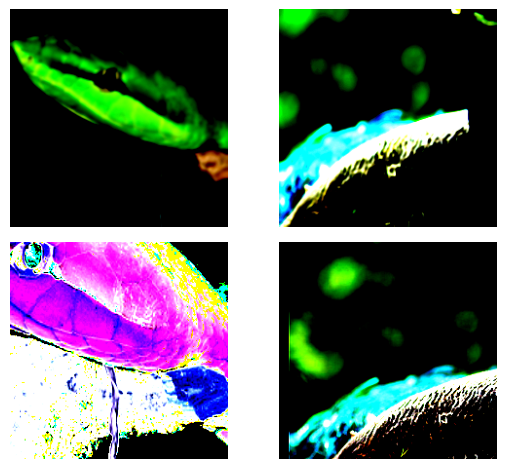

In [30]:
imgs,labels = next(iter(ssl_train_loader))

img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)


In [31]:
device = torch.device("cuda:0")  # Use GPU 0
last_filename = os.path.join(model_dir,"ssl",'ssl-epoch=99.ckpt')
print(last_filename)
#if os.path.isfile(last_filename):
#    print(f'Found pretrained model at {last_filename}, loading...')
#    ssl_model = lightning_models.CLAP.load_from_checkpoint(last_filename)
backbone = ssl_model.backbone.to(device)
# make sure the projection head is not removed
for name, param in ssl_model.backbone.projection_head.named_parameters():
    print(f"{name}: {param.shape}")

../simulation_imagenet/ssl/ssl-epoch=99.ckpt
0.weight: torch.Size([8192, 2048])
0.bias: torch.Size([8192])
2.weight: torch.Size([8192, 8192])
2.bias: torch.Size([8192])
4.weight: torch.Size([512, 8192])
4.bias: torch.Size([512])


In [32]:
def sample_embedding(net,data_loader,count=100):
    embedding_vecs = []
    i = 0
    for i,data in enumerate(data_loader):
        imgs,labels = data
        if i > count - 1:
            break
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = net(imgs)
            preds = torch.reshape(preds,(n_views,batch_size,preds.shape[-1]))
            # save as CPU tensor to save GPU memory
            embedding_vecs.append(preds.detach().cpu())
    embedding_vecs = torch.cat(embedding_vecs,dim=1)
    print(embedding_vecs.shape)
    # preds is [V,B*count,O] dimesional matrix
    com = torch.mean(embedding_vecs,dim=(0,1))
    # make the center of mass of pres locate at the origin
    #embedding_vecs -= com
    # normalize
    embedding_vecs = torch.nn.functional.normalize(embedding_vecs,dim=-1)
    # centers.shape = [B*count,O] for B*ws ellipsoids
    centers = torch.mean(embedding_vecs,dim=0)
    return centers

In [33]:
centers = sample_embedding(backbone,ssl_train_loader,count=100)


torch.Size([4, 800, 512])


In [34]:
print(centers.shape)

torch.Size([800, 512])


In [35]:
avg = torch.mean(centers,dim=0)**2
cov = torch.einsum("ij,ik->jk",centers,centers)/(centers.shape[0]-1.0) # size B*O*O
distances = torch.sqrt(torch.sum((centers[None,:,:] - centers[:,None,:])**2,dim=-1) + 1e-12)
distances = torch.flatten(distances).detach().cpu().numpy()
print(torch.trace(cov))
print(torch.norm(cov))
print(torch.norm(avg))
print(torch.norm(cov-torch.eye(512)/512.0))
torch.norm(centers[12])

tensor(0.9571)
tensor(0.9355)
tensor(0.0679)
tensor(0.9346)


tensor(0.9878)

(array([6.36696099e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.38847111e-02, 4.11767285e+00, 9.14852361e+00, 7.73808898e+00,
        5.91936139e+00, 4.60426959e+00, 3.71336942e+00, 3.07540250e+00,
        2.57113900e+00, 2.12720086e+00, 1.73945308e+00, 1.44752803e+00,
        1.16085748e+00, 9.37852999e-01, 7.21058059e-01, 5.52970353e-01,
        4.07804316e-01, 2.76962698e-01, 1.99285804e-01, 1.33387782e-01,
        8.57948971e-02, 5.50741081e-02, 3.18348412e-02, 1.46440270e-02,
        6.84447008e-03, 1.75091627e-03]),
 array([9.99999997e-07, 1.96336005e-02, 3.92661989e-02, 5.88987991e-02,
        7.85313994e-02, 9.81639996e-02, 1.17796600e-01, 1.37429208e-01,
        1.57061800e-01, 1.76694408e-01, 1.96327001e-01, 2.15959609e-01,
        2.35592201e-01, 2.55224794e-01, 2.74857402e-01, 2.94490010e-01,
        3.14122617e-01, 3.33755195e-01, 3.53387803e-01, 3.73020411e-01,
        3.92653018e-01, 4.12285596e-01, 4.31918204e-01, 4.51550812e-01,
        4.71183419e-01

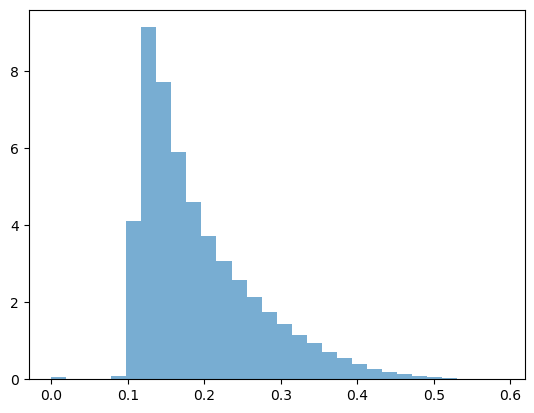

In [36]:
plt.hist(distances, bins=30, density=True, alpha=0.6, label='Empirical')

(array([1.39208752e-03, 2.78402719e-03, 2.78417503e-03, 0.00000000e+00,
        6.96043758e-03, 4.17626255e-03, 4.17604078e-03, 6.96043758e-03,
        1.11361088e-02, 1.25287876e-02, 1.53129627e-02, 3.06242991e-02,
        3.06259253e-02, 2.64482583e-02, 3.75863629e-02, 6.96043758e-02,
        7.09926933e-02, 8.90936010e-02, 1.09969074e-01, 1.08582826e-01,
        1.28072051e-01, 1.65649618e-01, 2.31086528e-01, 2.10194053e-01,
        2.72849153e-01, 2.81201678e-01, 3.25731181e-01, 4.17626255e-01,
        4.52404418e-01, 5.51266656e-01, 5.97205544e-01, 6.82086661e-01,
        8.11587021e-01, 9.59097366e-01, 9.96734661e-01, 1.19580318e+00,
        1.25420425e+00, 1.57305889e+00, 1.76368122e+00, 1.99346932e+00,
        2.27467100e+00, 2.53903280e+00, 2.97210685e+00, 3.33248054e+00,
        3.79831079e+00, 4.29737416e+00, 4.84699133e+00, 5.36788946e+00,
        6.03855497e+00, 6.88735298e+00, 7.38641636e+00, 8.25116058e+00,
        8.87107769e+00, 9.71973492e+00, 1.04977320e+01, 1.170397

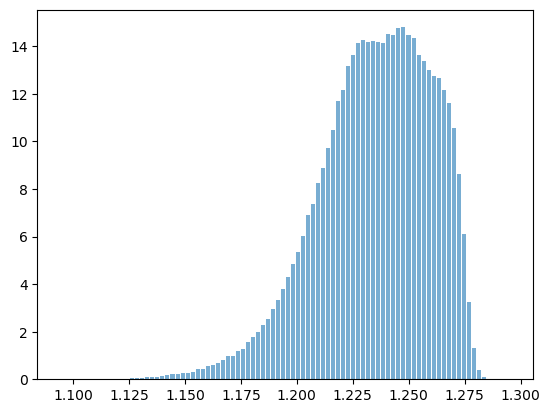

In [44]:
centers -= avg
cosine = torch.einsum('ik,jk->ij',centers,centers)
cosine = torch.flatten(cosine).detach().cpu().numpy()
plt.hist(cosine, bins=90,density=True, rwidth=0.8,alpha=0.6, label='Empirical')